<html>
   <body>
    <p style="font-size:30px; color:orange; font-family:'Courier New';text-align:center"> 
        Pilot 3 Validation : Patient Profiling</p>
  </body>
</html>

This code contains sections for : 
1. Patient Profiling
2. Quantile plots and correlation with episode length for dosage features and 

In [1]:
#import required libs
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

from datetime import datetime
from datetime import timedelta

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

import string
import regex
import sklearn
import html

import numpy
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings("ignore")

np.random.seed(123)


In [2]:
#import required datasets
all_features = pd.read_csv('Intermediate Outputs/202105 Feature Creation Output.csv')
monthly_dose = pd.read_csv('Intermediate Outputs/202105 Monthly Average Dose.csv')

### Code Setup

Function definitions used across the profiling section

In [3]:
#mapping categorical features
cleanup = {
    "DC Status": {
        "Yes": "1",
        "No": "0",
        "Discontinued": "1"
    },
    "Gender": {
        "M": 0,
        "F": 1
    },
    "Age": {
        65: 0,
        1: 1
    }
}

all_features = all_features.replace(cleanup)

In [4]:
#getting list of categorical columns
temp = pd.DataFrame(columns=['Column Name', 'len'])
i = 0

for col in all_features.columns:
    temp.loc[i, 'Column Name'] = col
    temp.loc[i, 'len'] = len(all_features[col].value_counts())
    i = i + 1

categorical_cols = temp[temp['len'] <= 4]
categorical_cols = categorical_cols[categorical_cols['len'] > 1]

categorical_cols = categorical_cols[
    categorical_cols['Column Name'] != 'DC Status']


In [5]:
#function to get t test results
from scipy import stats


def get_t_test(column, df):
    x = df.loc[df[column] == 0, 'Episode Length']
    y = df.loc[df[column] == 1, 'Episode Length']

    stat, pval = stats.ttest_ind(x, y, equal_var=True)

    return stat, pval

In [6]:
#function to generate graphs by quartile
def get_graph_by_cluster(df, col, cluster_col='Quartile'):
    
    
 #   if col not in categorical_cols['Column Name']:

        print(col)
        temp = df[['Patient ID', cluster_col, col]]
        temp.loc[temp[col] > 0, col] = 1

        temp = temp.groupby([cluster_col,
                             col]).count()[['Patient ID']].reset_index()
        
        temp = pd.merge(temp,
                        df.groupby([cluster_col]).count()[['Patient ID'
                                                           ]].reset_index(),
                        on=cluster_col)
        
        temp['percent'] = round(
            temp['Patient ID_x'] * 100 / temp['Patient ID_y'], 0)
    
        

        #plot the two classes across quartiles by groups 
        g = sns.barplot(data=temp, x=cluster_col, y="percent", hue=col)
        
        #to add labels to barplots - please uncomment if needed 
        
#        for index, data in enumerate(temp['percent']):
#             plt.text(x=index / 2.5,
#                      y=data + 1,
#                      s=f"{data}",
#                      fontdict=dict(fontsize=10))

        plt.show()
        
        #display patient counts and percent for the positive class 
        temp = temp.drop(columns = ['Patient ID_y'], axis = 1)
        temp.columns = ['Quartile', col, 'Patient Count', 'Percentage']
        print(temp[temp[col] == 1])
        
        print('')
        print('')
        
        #print t test results 
        stat, pval = get_t_test(col, df)
        print("T test statistic : ", round(stat, 3), "pval : ", round(pval, 3))
        
        print('')
        print('')

## Patient Profiling

Patient Profiling : We divide patients into 4 buckets based on episode length. For each of these buckets, we observe trends across all covariates. 

Profiling has been done for the following three samples - 
 * All patients with observed discontinuation (338 patients) 
 * All patients under study (531 patients) and 
 * All patients with observed discontinuation + patients who were censored in the 4 quartile (430 patients) 
 
In order to ensure that the episode length has been correctly represented, we have only reported results for patients with observed discontinuation (count = 338)

### Profiling without censored patients

In [7]:
#filtering for patients who dropped off 
true_drops = all_features[all_features['DC Status'] == "1"]
true_drops.shape

(338, 29)

In [8]:
#dividing patients into equal sized quartiles
true_drops['Quartile'] = pd.qcut(true_drops['Episode Length'],
                                 4,
                                 labels=[1, 2, 3, 4])

pd.DataFrame(true_drops['Quartile'].value_counts())

Quartile
4        85
1        85
3        84
2        84

In [9]:
#episode length distribution across quartiles
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)

    percentile_.__name__ = 'percentile_%s' % n
    return percentile_


true_drops.groupby(['Quartile']).agg([
    'min',
    percentile(25), 'median', 'mean',
    percentile(75),
    percentile(95), 'max', np.std
])[['Episode Length']]

Episode Length                                                 \
                    min percentile_25 median        mean percentile_75   
Quartile                                                                 
1                    28         28.00     28   39.764706         56.00   
2                    76        105.75    136  145.595238        183.00   
3                   225        286.50    354  351.023810        415.25   
4                   496        596.00    720  792.635294        903.00   

                                          
         percentile_95   max         std  
Quartile                                  
1                68.80    75   15.753796  
2               221.70   224   46.054739  
3               478.15   494   77.041371  
4              1332.40  1540  255.710069

Age


  Quartile  Age  Patient Count  Percentage
1        1    1             39        46.0
3        2    1             45        54.0
5        3    1             47        56.0
7        4    1             50        59.0


T test statistic :  -1.367 pval :  0.172


Gender


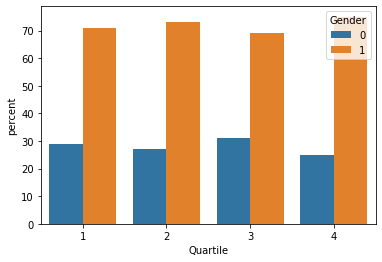

  Quartile  Gender  Patient Count  Percentage
1        1       1             60        71.0
3        2       1             61        73.0
5        3       1             58        69.0
7        4       1             64        75.0


T test statistic :  -1.246 pval :  0.214


Private Insurance


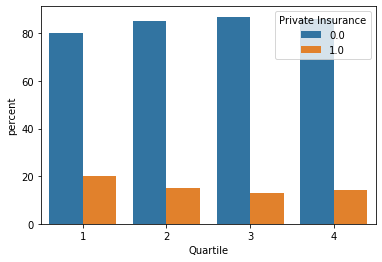

  Quartile  Private Insurance  Patient Count  Percentage
1        1                1.0             17        20.0
3        2                1.0             13        15.0
5        3                1.0             11        13.0
7        4                1.0             12        14.0


T test statistic :  0.82 pval :  0.413


ARBs


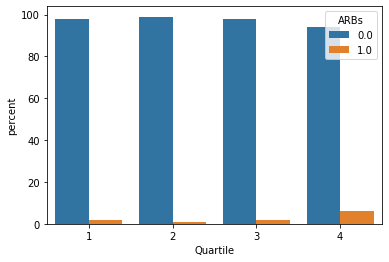

  Quartile  ARBs  Patient Count  Percentage
1        1   1.0              2         2.0
3        2   1.0              1         1.0
5        3   1.0              2         2.0
7        4   1.0              5         6.0


T test statistic :  -1.304 pval :  0.193


Diuretics


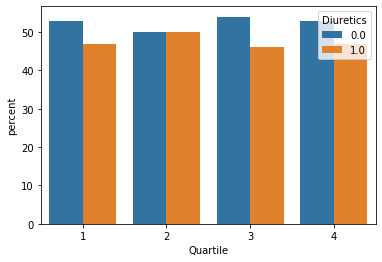

  Quartile  Diuretics  Patient Count  Percentage
1        1        1.0             40        47.0
3        2        1.0             42        50.0
5        3        1.0             39        46.0
7        4        1.0             40        47.0


T test statistic :  0.679 pval :  0.497


ERA


  Quartile  ERA  Patient Count  Percentage
1        1  1.0             35        41.0
3        2  1.0             46        55.0
5        3  1.0             40        48.0
7        4  1.0             47        55.0


T test statistic :  -0.729 pval :  0.466


PDE5


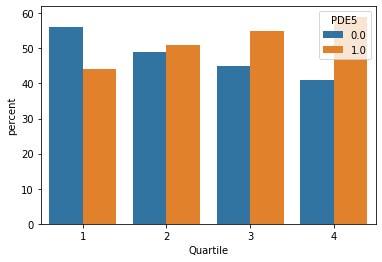

  Quartile  PDE5  Patient Count  Percentage
1        1   1.0             37        44.0
3        2   1.0             43        51.0
5        3   1.0             46        55.0
7        4   1.0             50        59.0


T test statistic :  -0.77 pval :  0.442


ambrisentan


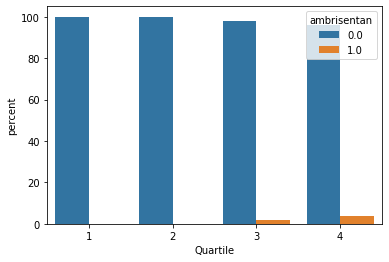

  Quartile  ambrisentan  Patient Count  Percentage
1        1          1.0            NaN         NaN
3        2          1.0            NaN         NaN
5        3          1.0            2.0         2.0
7        4          1.0            3.0         4.0


T test statistic :  -1.604 pval :  0.11


bosentan


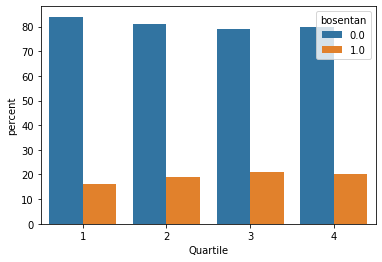

  Quartile  bosentan  Patient Count  Percentage
1        1       1.0             14        16.0
3        2       1.0             16        19.0
5        3       1.0             18        21.0
7        4       1.0             17        20.0


T test statistic :  -0.495 pval :  0.621


macitentan


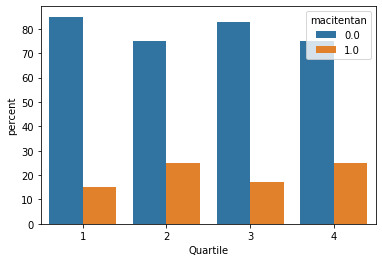

  Quartile  macitentan  Patient Count  Percentage
1        1         1.0             13        15.0
3        2         1.0             21        25.0
5        3         1.0             14        17.0
7        4         1.0             21        25.0


T test statistic :  -0.917 pval :  0.36


oxygen


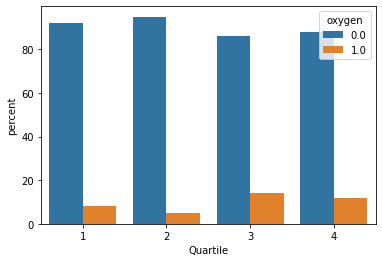

  Quartile  oxygen  Patient Count  Percentage
1        1     1.0              7         8.0
3        2     1.0              4         5.0
5        3     1.0             12        14.0
7        4     1.0             10        12.0


T test statistic :  -1.613 pval :  0.108


sildenafil


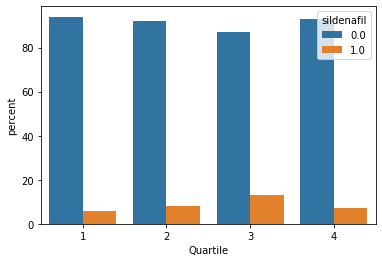

  Quartile  sildenafil  Patient Count  Percentage
1        1         1.0              5         6.0
3        2         1.0              7         8.0
5        3         1.0             11        13.0
7        4         1.0              6         7.0


T test statistic :  0.325 pval :  0.746


tadalafil


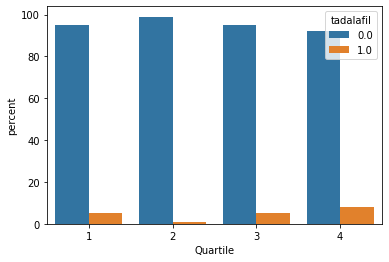

  Quartile  tadalafil  Patient Count  Percentage
1        1        1.0              4         5.0
3        2        1.0              1         1.0
5        3        1.0              4         5.0
7        4        1.0              7         8.0


T test statistic :  -1.394 pval :  0.164




In [10]:
for col in categorical_cols['Column Name']:
    get_graph_by_cluster(true_drops, col)

In [11]:
#true_drops.loc[(true_drops['Quartile'] == 1) & (true_drops['Time To First Maintenence'] != 0)].reset_index(drop = True)
#monthly_dose[monthly_dose['Patient ID'] == '1-10291616222']

Erollment To Shipping Days
4    85
1    85
3    84
2    84
Name: Quartile, dtype: int64


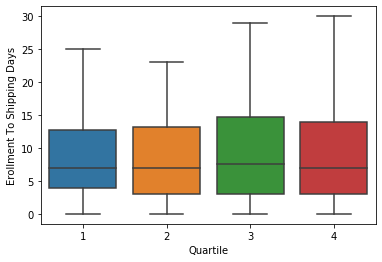

First Monthly Average Dose
4    85
1    85
3    84
2    84
Name: Quartile, dtype: int64


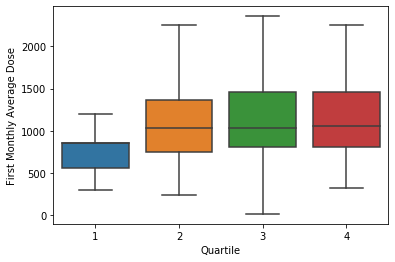

Last Monthly Average Dose
4    85
1    85
3    84
2    84
Name: Quartile, dtype: int64


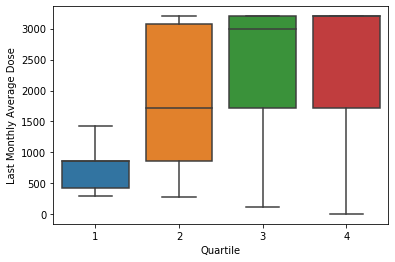

Time To First Maintenence
4    85
3    84
2    59
1    22
Name: Quartile, dtype: int64


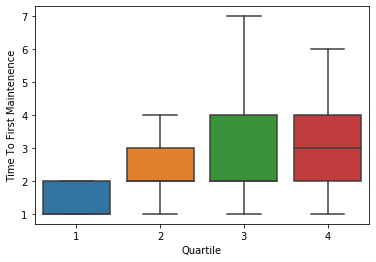

First Maintenence Dose
4    85
3    84
2    59
1    22
Name: Quartile, dtype: int64


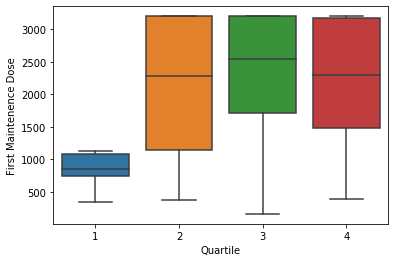

Average Maintenence Dose
4    85
3    84
2    59
1    22
Name: Quartile, dtype: int64


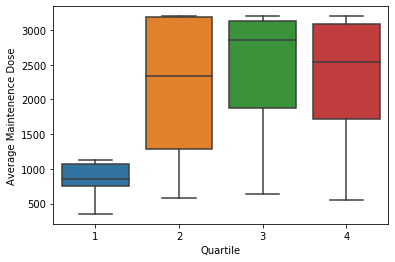

In [13]:
#Continuous Columns Box Plots

continuous_cols = [
    'Erollment To Shipping Days', 'First Monthly Average Dose',
    'Last Monthly Average Dose', 'Time To First Maintenence',
    'First Maintenence Dose', 'Average Maintenence Dose'
]

""" 
For the maintenence doses, we have 88 patients who never reach a maintainence phase - 
either due to a limited number of claims, or
because the dose fluctuations across months were very high. 
For these patients, all titration related values have been recorded as zero and will be dropped here
"""

for col in continuous_cols:
    if col in ['First Monthly Average Dose', 'Last Monthly Average Dose', 'Erollment To Shipping Days'] : 
        temp = true_drops.copy(deep = True)
    else : 
        temp = true_drops[true_drops[col] != 0]
        
    print(col)
    print(temp['Quartile'].value_counts())
    
    x = sns.boxplot(data=temp, x="Quartile", y=col, showfliers=False)
    plt.show()

In [13]:
true_drops.replace(0, np.nan).groupby(['Quartile']).agg(['mean', 'median'])[[
    'First Monthly Average Dose', 'Last Monthly Average Dose',
    'Time To First Maintenence', 'First Maintenence Dose',
    'Average Maintenence Dose'
]]

First Monthly Average Dose         Last Monthly Average Dose          \
                               mean  median                      mean  median   
Quartile                                                                        
1                        956.458824   857.0               1026.764706   857.0   
2                       1159.904762  1033.0               1892.797619  1714.0   
3                       1209.190476  1040.0               2369.940476  3000.0   
4                       1230.564706  1058.0               2507.447059  3200.0   

         Time To First Maintenence        First Maintenence Dose               \
                              mean median                   mean       median   
Quartile                                                                        
1                         1.409091    1.0            1328.295455   857.000000   
2                         2.254237    2.0            2119.124859  2289.333333   
3                         2.976190    2.0            2348.421825  2537.883333   
4                         3.047059    3.0            2207.828235  2303.333333   

         Average Maintenence Dose               
                             mean       median  
Quartile                                        
1                     1325.079545   857.000000  
2                     2161.441158  2343.550000  
3                     2429.950249  2859.490000  
4                     2336.045344  2545.793939

### Profiling with all censored Patients

In [14]:
all_features['Quartile'] = pd.qcut(all_features['Episode Length'],
                                   4,
                                   labels=['1', '2', '3', '4'])
pd.DataFrame(all_features['Quartile'].value_counts())

Quartile
1       134
4       133
3       132
2       132

In [15]:
#episode length distribution across quartiles
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)

    percentile_.__name__ = 'percentile_%s' % n
    return percentile_


all_features.groupby(['Quartile']).agg([
    'min',
    percentile(25), 'median', 'mean',
    percentile(75),
    percentile(95), 'max', np.std
])[['Episode Length']]

Episode Length                                                  \
                    min percentile_25 median         mean percentile_75   
Quartile                                                                  
1                    28          28.0     36    49.641791         68.75   
2                   106         142.5    195   200.439394        249.75   
3                   315         365.0    441   454.992424        531.75   
4                   654         775.0    938  1026.375940       1247.00   

                                          
         percentile_95   max         std  
Quartile                                  
1                 97.7   105   25.180074  
2                301.0   309   62.303157  
3                633.8   651   95.762070  
4               1628.4  1710  301.454972

DC Status


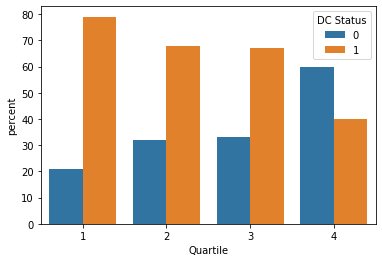

  Quartile  DC Status  Patient Count  Percentage
1        1          1            106        79.0
3        2          1             90        68.0
5        3          1             89        67.0
7        4          1             53        40.0


T test statistic :  7.912 pval :  0.0




In [16]:
all_features['DC Status'] = all_features['DC Status'].astype(int)
get_graph_by_cluster(all_features, 'DC Status')

Age


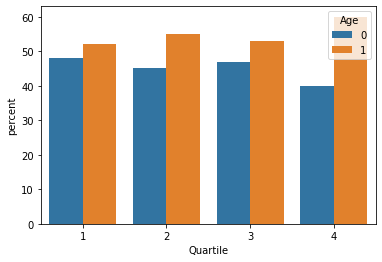

  Quartile  Age  Patient Count  Percentage
1        1    1             70        52.0
3        2    1             72        55.0
5        3    1             70        53.0
7        4    1             80        60.0


T test statistic :  -1.959 pval :  0.051


Gender


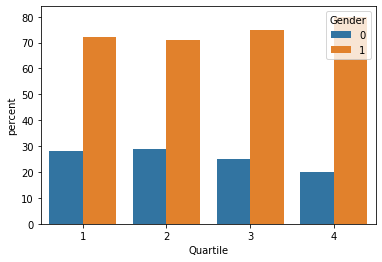

  Quartile  Gender  Patient Count  Percentage
1        1       1             97        72.0
3        2       1             94        71.0
5        3       1             99        75.0
7        4       1            106        80.0


T test statistic :  -1.713 pval :  0.087


Private Insurance


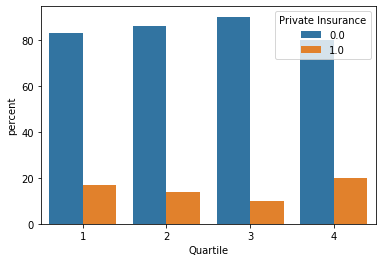

  Quartile  Private Insurance  Patient Count  Percentage
1        1                1.0             23        17.0
3        2                1.0             19        14.0
5        3                1.0             13        10.0
7        4                1.0             26        20.0


T test statistic :  -1.52 pval :  0.129


ARBs


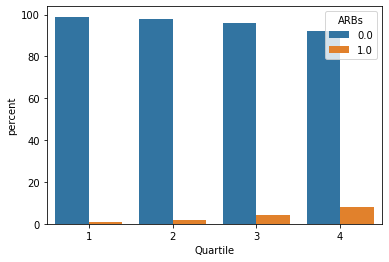

  Quartile  ARBs  Patient Count  Percentage
1        1   1.0              2         1.0
3        2   1.0              3         2.0
5        3   1.0              5         4.0
7        4   1.0             11         8.0


T test statistic :  -2.28 pval :  0.023


Diuretics


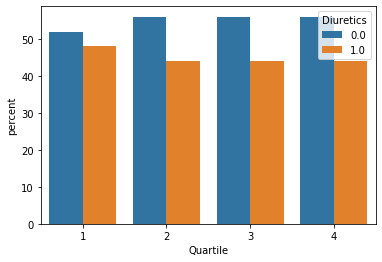

  Quartile  Diuretics  Patient Count  Percentage
1        1        1.0             64        48.0
3        2        1.0             58        44.0
5        3        1.0             58        44.0
7        4        1.0             58        44.0


T test statistic :  0.108 pval :  0.914


ERA


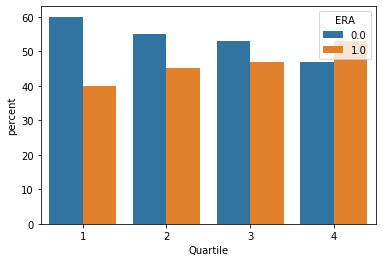

  Quartile  ERA  Patient Count  Percentage
1        1  1.0             53        40.0
3        2  1.0             60        45.0
5        3  1.0             62        47.0
7        4  1.0             71        53.0


T test statistic :  -2.486 pval :  0.013


PDE5


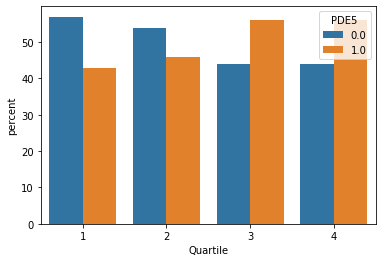

  Quartile  PDE5  Patient Count  Percentage
1        1   1.0             58        43.0
3        2   1.0             61        46.0
5        3   1.0             74        56.0
7        4   1.0             74        56.0


T test statistic :  -1.981 pval :  0.048


ambrisentan


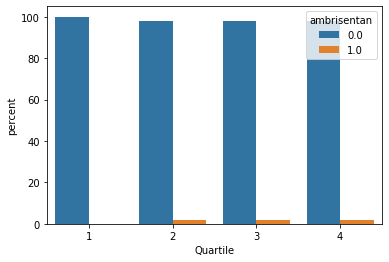

  Quartile  ambrisentan  Patient Count  Percentage
1        1          1.0            NaN         NaN
3        2          1.0            2.0         2.0
5        3          1.0            3.0         2.0
7        4          1.0            2.0         2.0


T test statistic :  -0.474 pval :  0.636


bosentan


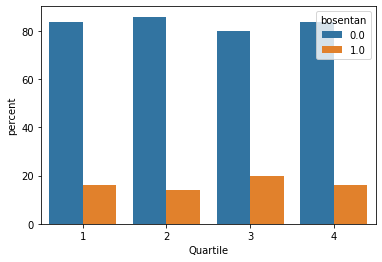

  Quartile  bosentan  Patient Count  Percentage
1        1       1.0             21        16.0
3        2       1.0             19        14.0
5        3       1.0             27        20.0
7        4       1.0             21        16.0


T test statistic :  -0.364 pval :  0.716


macitentan


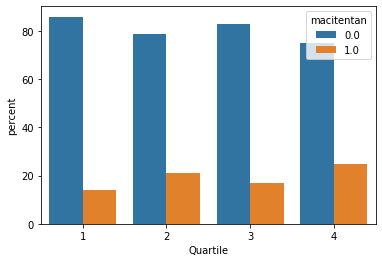

  Quartile  macitentan  Patient Count  Percentage
1        1         1.0             19        14.0
3        2         1.0             28        21.0
5        3         1.0             22        17.0
7        4         1.0             33        25.0


T test statistic :  -2.49 pval :  0.013


oxygen


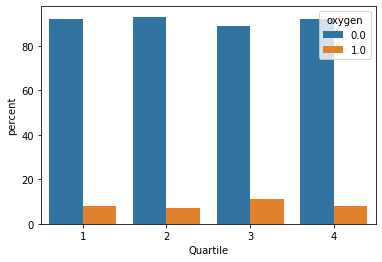

  Quartile  oxygen  Patient Count  Percentage
1        1     1.0             11         8.0
3        2     1.0              9         7.0
5        3     1.0             14        11.0
7        4     1.0             11         8.0


T test statistic :  0.185 pval :  0.853


sildenafil


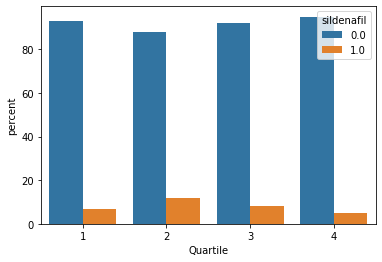

  Quartile  sildenafil  Patient Count  Percentage
1        1         1.0             10         7.0
3        2         1.0             16        12.0
5        3         1.0             11         8.0
7        4         1.0              7         5.0


T test statistic :  1.515 pval :  0.13


tadalafil


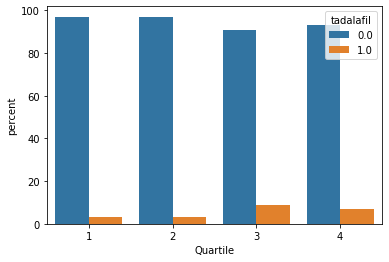

  Quartile  tadalafil  Patient Count  Percentage
1        1        1.0              4         3.0
3        2        1.0              4         3.0
5        3        1.0             12         9.0
7        4        1.0              9         7.0


T test statistic :  -1.394 pval :  0.164




In [17]:
for col in categorical_cols['Column Name']:
    get_graph_by_cluster(all_features, col)

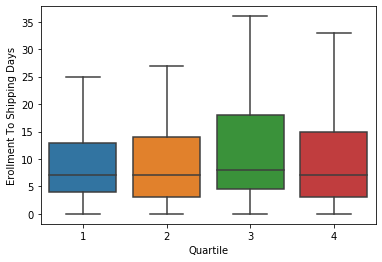

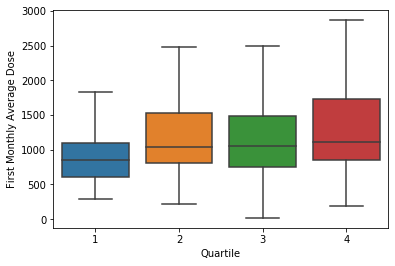

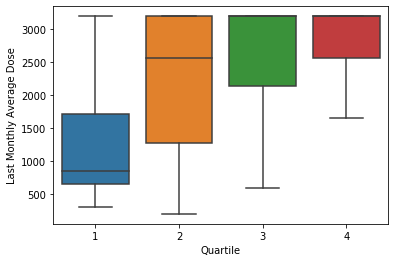

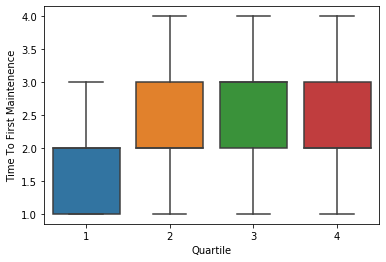

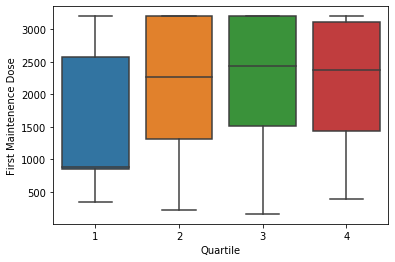

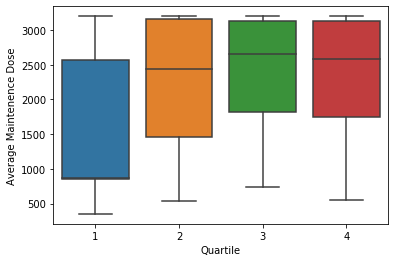

In [18]:
#Continuous Columns Box Plots

continuous_cols = [
    'Erollment To Shipping Days', 'First Monthly Average Dose',
    'Last Monthly Average Dose', 'Time To First Maintenence',
    'First Maintenence Dose', 'Average Maintenence Dose'
]
for col in continuous_cols:
    if col in ['First Monthly Average Dose', 'Last Monthly Average Dose', 'Erollment To Shipping Days'] : 
        temp = all_features.copy(deep = True)
    else : 
        temp = all_features[all_features[col] != 0]
    
    x = sns.boxplot(data=temp, y=col, x="Quartile", showfliers=False)
    plt.show()

In [19]:
all_features.replace(0, np.nan).groupby(['Quartile']).agg(['mean', 'median'])[[
    'First Monthly Average Dose', 'Last Monthly Average Dose',
    'Time To First Maintenence', 'First Maintenence Dose',
    'Average Maintenence Dose'
]]

First Monthly Average Dose         Last Monthly Average Dose          \
                               mean  median                      mean  median   
Quartile                                                                        
1                        984.925373   857.0               1233.902985   857.0   
2                       1240.810606  1044.0               2218.454545  2571.0   
3                       1252.090909  1053.0               2554.477273  3200.0   
4                       1379.007519  1114.0               2727.804511  3200.0   

         Time To First Maintenence        First Maintenence Dose               \
                              mean median                   mean       median   
Quartile                                                                        
1                         1.605263    2.0            1565.445614   891.300000   
2                         2.672566    2.0            2157.718879  2262.533333   
3                         2.939394    3.0            2278.476515  2436.600000   
4                         2.729323    2.0            2192.527820  2376.266667   

         Average Maintenence Dose               
                             mean       median  
Quartile                                        
1                     1565.366228   874.150000  
2                     2247.966651  2432.700000  
3                     2420.529060  2661.913360  
4                     2383.683953  2588.617391

### Profiling including censored patients in the 4th Quartile

In [20]:
censor = all_features[all_features['Episode Length'] >= 496]
censor = censor[censor['DC Status'] == 0]
censor['Quartile'] = 4
some_drops = true_drops.append(censor)

In [21]:
pd.DataFrame(some_drops['Quartile'].value_counts())

Quartile
4       177
1        85
3        84
2        84

In [22]:
len(some_drops)

430

In [23]:
#episode length distributions by quartile
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)

    percentile_.__name__ = 'percentile_%s' % n
    return percentile_


some_drops.groupby(['Quartile']).agg([
    'min',
    percentile(25), 'median', 'mean',
    percentile(75),
    percentile(95), 'max', np.std
])[['Episode Length']]

Episode Length                                                 \
                    min percentile_25 median        mean percentile_75   
Quartile                                                                 
1                    28         28.00     28   39.764706         56.00   
2                    76        105.75    136  145.595238        183.00   
3                   225        286.50    354  351.023810        415.25   
4                   496        654.00    809  912.903955       1097.00   

                                          
         percentile_95   max         std  
Quartile                                  
1                68.80    75   15.753796  
2               221.70   224   46.054739  
3               478.15   494   77.041371  
4              1542.60  1710  328.400578

DC Status


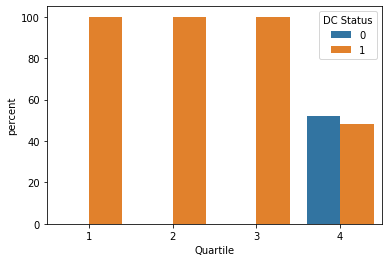

   Quartile  DC Status  Patient Count  Percentage
0         1          1             85       100.0
1         2          1             84       100.0
2         3          1             84       100.0
4         4          1             85        48.0


T test statistic :  18.02 pval :  0.0




In [24]:
some_drops['DC Status'] = some_drops['DC Status'].astype(int)
get_graph_by_cluster(some_drops, 'DC Status')

Age


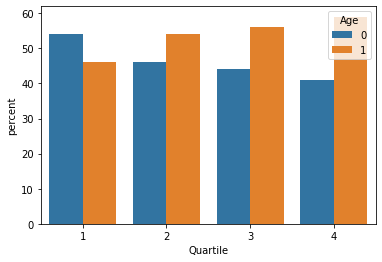

   Quartile  Age  Patient Count  Percentage
1         1    1             39        46.0
3         2    1             45        54.0
5         3    1             47        56.0
7         4    1            104        59.0


T test statistic :  -2.365 pval :  0.018


Gender


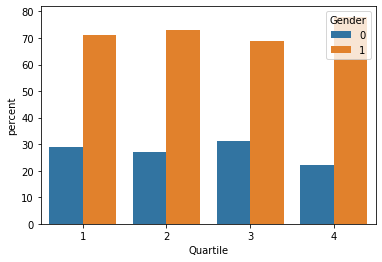

   Quartile  Gender  Patient Count  Percentage
1         1       1             60        71.0
3         2       1             61        73.0
5         3       1             58        69.0
7         4       1            138        78.0


T test statistic :  -1.923 pval :  0.055


Private Insurance


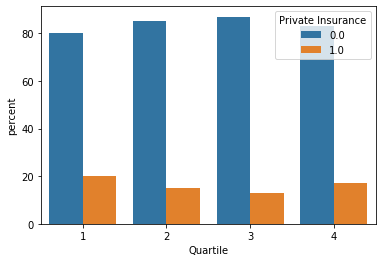

   Quartile  Private Insurance  Patient Count  Percentage
1         1                1.0             17        20.0
3         2                1.0             13        15.0
5         3                1.0             11        13.0
7         4                1.0             30        17.0


T test statistic :  -1.138 pval :  0.256


ARBs


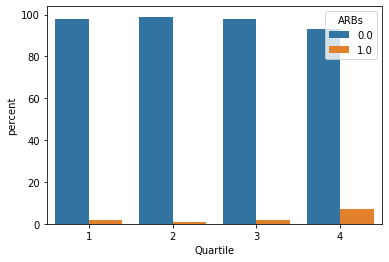

   Quartile  ARBs  Patient Count  Percentage
1         1   1.0              2         2.0
3         2   1.0              1         1.0
5         3   1.0              2         2.0
7         4   1.0             12         7.0


T test statistic :  -2.196 pval :  0.029


Diuretics


   Quartile  Diuretics  Patient Count  Percentage
1         1        1.0             40        47.0
3         2        1.0             42        50.0
5         3        1.0             39        46.0
7         4        1.0             80        45.0


T test statistic :  0.524 pval :  0.601


ERA


   Quartile  ERA  Patient Count  Percentage
1         1  1.0             35        41.0
3         2  1.0             46        55.0
5         3  1.0             40        48.0
7         4  1.0             95        54.0


T test statistic :  -1.688 pval :  0.092


PDE5


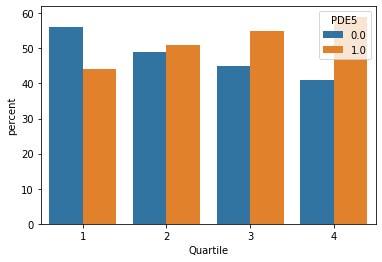

   Quartile  PDE5  Patient Count  Percentage
1         1   1.0             37        44.0
3         2   1.0             43        51.0
5         3   1.0             46        55.0
7         4   1.0            104        59.0


T test statistic :  -1.426 pval :  0.155


ambrisentan


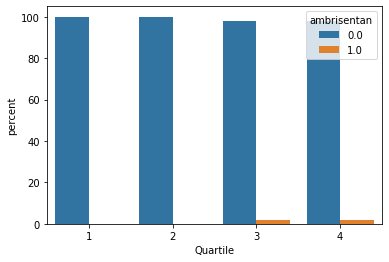

   Quartile  ambrisentan  Patient Count  Percentage
3         3          1.0              2         2.0
5         4          1.0              4         2.0


T test statistic :  -0.445 pval :  0.657


bosentan


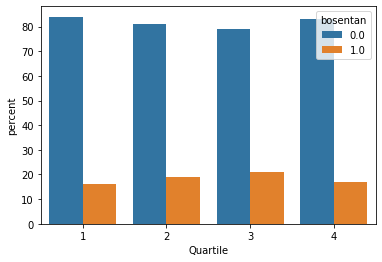

   Quartile  bosentan  Patient Count  Percentage
1         1       1.0             14        16.0
3         2       1.0             16        19.0
5         3       1.0             18        21.0
7         4       1.0             30        17.0


T test statistic :  0.093 pval :  0.926


macitentan


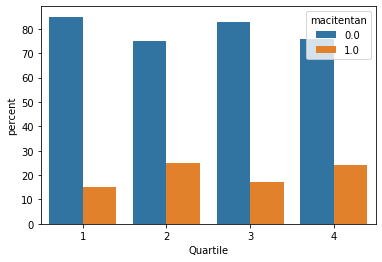

   Quartile  macitentan  Patient Count  Percentage
1         1         1.0             13        15.0
3         2         1.0             21        25.0
5         3         1.0             14        17.0
7         4         1.0             42        24.0


T test statistic :  -2.059 pval :  0.04


oxygen


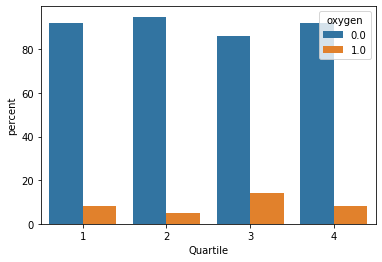

   Quartile  oxygen  Patient Count  Percentage
1         1     1.0              7         8.0
3         2     1.0              4         5.0
5         3     1.0             12        14.0
7         4     1.0             14         8.0


T test statistic :  0.077 pval :  0.939


sildenafil


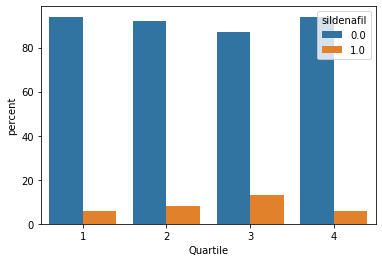

   Quartile  sildenafil  Patient Count  Percentage
1         1         1.0              5         6.0
3         2         1.0              7         8.0
5         3         1.0             11        13.0
7         4         1.0             11         6.0


T test statistic :  1.221 pval :  0.223


tadalafil


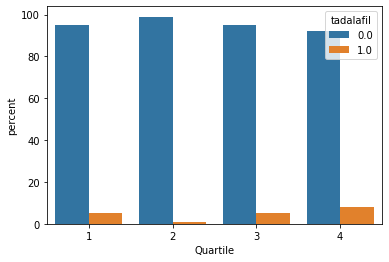

   Quartile  tadalafil  Patient Count  Percentage
1         1        1.0              4         5.0
3         2        1.0              1         1.0
5         3        1.0              4         5.0
7         4        1.0             15         8.0


T test statistic :  -1.295 pval :  0.196




In [25]:
for col in categorical_cols['Column Name']:
    get_graph_by_cluster(some_drops, col)

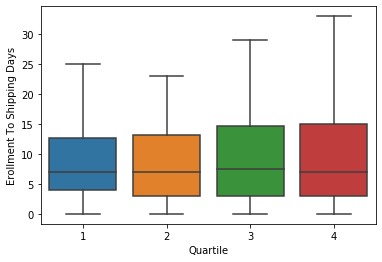

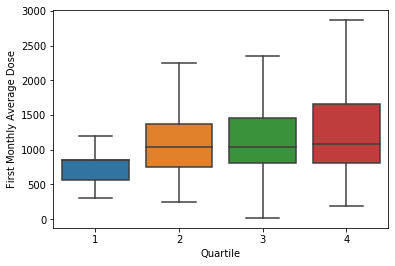

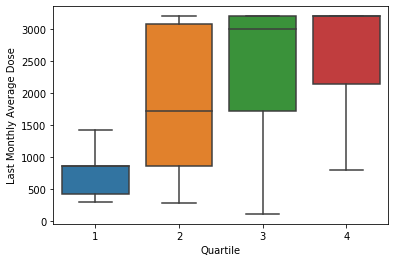

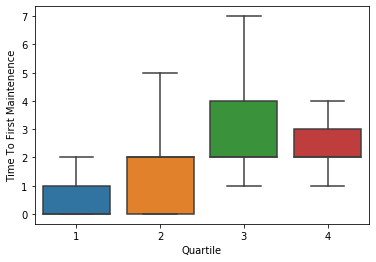

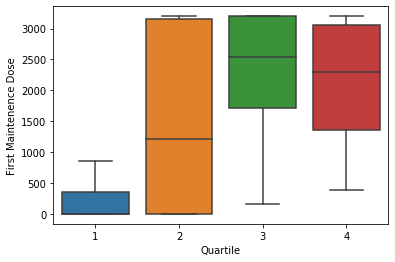

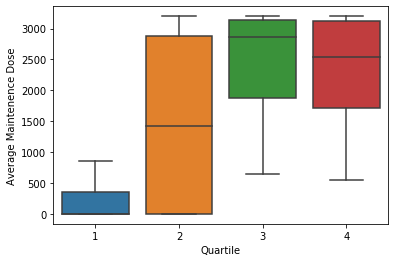

In [26]:
#Continuous Columns Box Plots

continuous_cols = [
    'Erollment To Shipping Days', 'First Monthly Average Dose',
    'Last Monthly Average Dose', 'Time To First Maintenence',
    'First Maintenence Dose', 'Average Maintenence Dose'
]

for col in continuous_cols:
    if col in ['First Monthly Average Dose', 'Last Monthly Average Dose', 'Erollment To Shipping Days'] : 
        temp = all_features.copy(deep = True)
    else : 
        temp = all_features[all_features[col] != 0]
        
    x = sns.boxplot(data=some_drops, x="Quartile", y=col, showfliers=False)
    plt.show()

In [27]:
some_drops.replace(0, np.nan).groupby(['Quartile']).agg(['mean', 'median'])[[
    'First Monthly Average Dose', 'Last Monthly Average Dose',
    'Time To First Maintenence', 'First Maintenence Dose',
    'Average Maintenence Dose', 'Erollment To Shipping Days'
]]

First Monthly Average Dose         Last Monthly Average Dose          \
                               mean  median                      mean  median   
Quartile                                                                        
1                        956.458824   857.0               1026.764706   857.0   
2                       1159.904762  1033.0               1892.797619  1714.0   
3                       1209.190476  1040.0               2369.940476  3000.0   
4                       1311.305085  1080.0               2688.333333  3200.0   

         Time To First Maintenence        First Maintenence Dose               \
                              mean median                   mean       median   
Quartile                                                                        
1                         1.409091    1.0            1328.295455   857.000000   
2                         2.254237    2.0            2119.124859  2289.333333   
3                         2.976190    2.0            2348.421825  2537.883333   
4                         2.813559    2.0            2146.671751  2296.933333   

         Average Maintenence Dose              Erollment To Shipping Days  \
                             mean       median                       mean   
Quartile                                                                    
1                     1325.079545   857.000000                  13.705128   
2                     2161.441158  2343.550000                  15.373333   
3                     2429.950249  2859.490000                  19.301370   
4                     2344.681946  2545.793939                  26.523179   

                 
         median  
Quartile         
1           8.0  
2           7.0  
3           8.0  
4           8.0

## Quantile Plots

We observe the trends in episode length across different buckets of the given feature


First Monthly Average Dose
           Quantile  Episode Length  Patient Count
0   (17.999, 467.1]            63.5             34
1    (467.1, 669.0]           125.0             34
2    (669.0, 800.0]           232.0             37
3    (800.0, 857.0]            28.0             39
4    (857.0, 956.0]           365.0             25
5   (956.0, 1074.6]           367.0             34
6  (1074.6, 1269.6]           327.0             33
7  (1269.6, 1483.6]           296.0             34
8  (1483.6, 2078.6]           312.0             34
9  (2078.6, 3200.0]           230.5             34


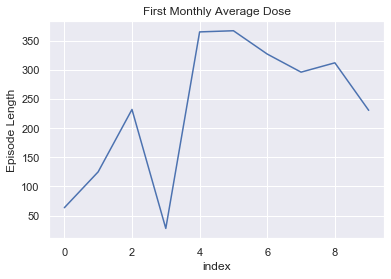


Last Monthly Average Dose
       Quantile  Episode Length  Patient Count
0     (0, 1286]            83.0            138
1  (1286, 2571]           228.0             76
2  (2571, 3200]           410.5            124


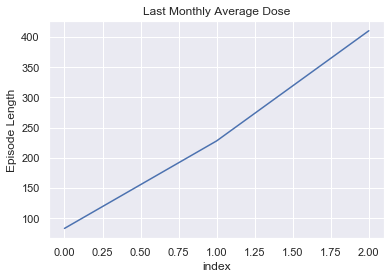


Erollment To Shipping Days
        Quantile  Episode Length  Patient Count
0  (-0.001, 3.0]           249.0             85
1     (3.0, 6.0]           174.0             56
2     (6.0, 8.0]           221.0             58
3    (8.0, 15.0]           216.0             59
4  (15.0, 696.0]           267.0             63


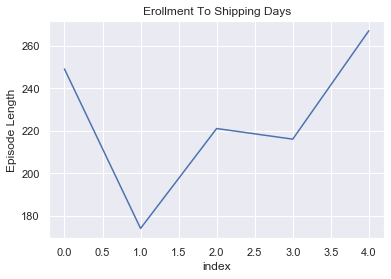


First Maintenence Dose
               Quantile  Episode Length  Patient Count
0   (163.999, 1106.447]           181.0             50
1  (1106.447, 1865.573]           425.5             50
2   (1865.573, 2622.84]           443.0             50
3     (2622.84, 3200.0]           356.5            100



Average Maintenence Dose
               Quantile  Episode Length  Patient Count
0   (349.999, 1218.272]           170.0             50
1  (1218.272, 2066.676]           439.0             50
2  (2066.676, 2904.958]           434.0             50
3  (2904.958, 3150.048]           450.5             50
4    (3150.048, 3200.0]           253.0             50


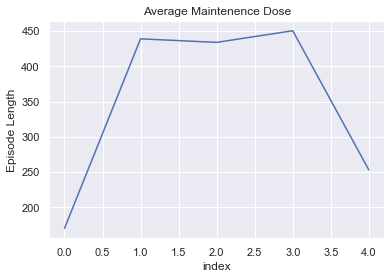


Time To First Maintenence
   Quantile  Episode Length  Patient Count
0       1.0           176.5             48
1       2.0           319.0             95
2       3.0           441.0             56
3       4.0           442.0             51


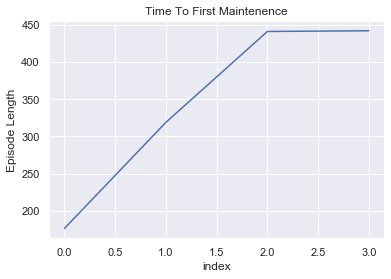

In [13]:
# quantile plots

continuous_cols = [
    'First Monthly Average Dose', 'Last Monthly Average Dose',
    'Erollment To Shipping Days', 'First Maintenence Dose',
    'Average Maintenence Dose', 'Time To First Maintenence'
]

for col in continuous_cols:
    print('')
    print(col)
    
    """ 
    For the maintenence doses, we have 88 patients who never reach a maintainence phase - 
    either due to a limited number of claims, or
    because the dose fluctuations across months were very high. 
    For these patients, all titration related values have been recorded as zero and will be dropped here
    """

    if col in [
            'First Monthly Average Dose', 'Last Monthly Average Dose',
            'Erollment To Shipping Days'
    ]:
        temp = true_drops.copy(deep=True)

    else:
        temp = true_drops[true_drops[col] != 0]
    """ 
    Due to distinct deciles not being available for all variables, we select : 
        i.   deciles for first monthly dose
        ii.  4 for time to first maintenence and 
        iii. 5 for all other variables 
    """

    if col in ['First Monthly Average Dose']:
        
        temp['Quantile'] = pd.qcut(temp[col], 10, duplicates='drop')

    elif col in ['Time To First Maintenence']:
        temp['Quantile'] = temp[col]
        temp.loc[temp['Quantile'] > 4, 'Quantile'] = 4

        
    elif col in ['Last Monthly Average Dose']:
        bins = pd.IntervalIndex.from_tuples([(0, 1286), (1286, 2571), (2571, 3200)])
        temp['Quantile'] = pd.cut(temp[col], bins)


        pd.cut(temp[col], [1286, 2571])
        
        
    else:
       
        temp['Quantile'] = pd.qcut(temp[col], 5, duplicates='drop')

    #getting patient count and median episode length for each quantile
    x = pd.DataFrame(
        temp.groupby(['Quantile'
                      ]).agg('median')['Episode Length']).reset_index()

    y = pd.DataFrame(temp['Quantile'].value_counts()).reset_index()
    y.columns = ['Quantile', 'Patient Count']

    res = pd.merge(x, y, how="inner", on="Quantile")

    #getting the correlation factor for given column with episode length
    #print('')
    #print("Correlation : ", round(temp.corr().loc[col, 'Episode Length'], 3))
    #print('')

    #displaying the final graphs
    print(res)
    sns.set()
    sns.lineplot(data=res.reset_index(drop=False),
                 x="index",
                 y="Episode Length").set_title(col)
    plt.show()